# GAN + Generación de datos agrícolas sintéticos + Análisis

In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Generación de datos agrícolas sintéticos base

In [2]:
cultivos = ["maíz", "trigo", "soja", "papa"]
dias = pd.date_range("2024-01-01", "2024-12-31")

def generar_datos_finca():
    registros = []
    for fecha in dias:
        cultivo = random.choice(cultivos)
        hectareas = round(np.random.uniform(1.0, 10.0), 2)
        temp = round(np.random.normal(25, 5), 1)
        lluvia = max(0, round(np.random.exponential(5), 1))
        humedad = round(np.random.normal(60, 15), 1)
        fertilizante = round(hectareas * np.random.uniform(2.0, 5.0), 1)

        factor_cultivo = {"maíz": 800, "trigo": 700, "soja": 600, "papa": 1000}
        base = hectareas * factor_cultivo[cultivo]

        clima_ajuste = 1.0
        if temp < 20 or temp > 32:
            clima_ajuste -= 0.15
        if humedad < 40 or humedad > 80:
            clima_ajuste -= 0.1
        if lluvia < 1.0:
            clima_ajuste -= 0.1

        produccion = round(base * clima_ajuste * np.random.uniform(0.9, 1.1), 1)

        registros.append({
            "hectareas": hectareas,
            "temperatura": temp,
            "precipitacion": lluvia,
            "humedad_suelo": humedad,
            "fertilizante_kg": fertilizante,
            "produccion_kg": produccion
        })

    return pd.DataFrame(registros)

# Generar datos y normalizar
df = generar_datos_finca()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values)
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

input_dim = data_tensor.shape[1]
latent_dim = 16

### Definición de la red GAN

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

### Entrenamiento de la GAN

In [4]:
epochs = 3000
batch_size = 64

for epoch in range(epochs):
    idx = np.random.randint(0, data_tensor.shape[0], batch_size)
    real_batch = data_tensor[idx]

    z = torch.randn(batch_size, latent_dim)
    fake_batch = generator(z).detach()

    d_loss_real = criterion(discriminator(real_batch), torch.ones(batch_size, 1))
    d_loss_fake = criterion(discriminator(fake_batch), torch.zeros(batch_size, 1))
    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    z = torch.randn(batch_size, latent_dim)
    fake_batch = generator(z)
    g_loss = criterion(discriminator(fake_batch), torch.ones(batch_size, 1))

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

Epoch 0 | D_loss: 1.3919 | G_loss: 0.6158
Epoch 500 | D_loss: 1.2411 | G_loss: 0.8121
Epoch 1000 | D_loss: 1.6188 | G_loss: 0.6129
Epoch 1500 | D_loss: 1.5430 | G_loss: 0.6662
Epoch 2000 | D_loss: 1.2965 | G_loss: 0.7127
Epoch 2500 | D_loss: 1.3686 | G_loss: 0.6438


### Generación y exportación de nuevos datos

In [5]:
z = torch.randn(1000, latent_dim)
synthetic_data = generator(z).detach().numpy()
synthetic_data_original = scaler.inverse_transform(synthetic_data)

df_sintetico = pd.DataFrame(synthetic_data_original, columns=df.columns)
df_sintetico.to_csv("datos_agricolas_sinteticos_por_GAN.csv", index=False)
print("\nDatos sinteticos generados:")
print(df_sintetico.head())


Datos sinteticos generados:
   hectareas  temperatura  precipitacion  humedad_suelo  fertilizante_kg  \
0   7.771873    28.691225       2.326546      69.303940        28.940582   
1   9.493928    28.245975       0.233006      46.712425        43.707020   
2   1.067722    37.487347       0.037489      96.250122         2.751129   
3   6.577706    27.309757       0.971907      77.776161        26.663395   
4   9.290337    25.992699       1.389059      65.866707        38.038296   

   produccion_kg  
0    2882.967041  
1    1111.760498  
2     704.438110  
3    2158.570312  
4    2303.593994  


### Análisis de los datos generados


Matriz de correlación:
                 hectareas  temperatura  precipitacion  humedad_suelo  \
hectareas         1.000000    -0.795026       0.263858      -0.860878   
temperatura      -0.795026     1.000000      -0.454534       0.713936   
precipitacion     0.263858    -0.454534       1.000000      -0.353262   
humedad_suelo    -0.860878     0.713936      -0.353262       1.000000   
fertilizante_kg   0.987818    -0.770817       0.219311      -0.890924   
produccion_kg     0.634900    -0.732549       0.725911      -0.470537   

                 fertilizante_kg  produccion_kg  
hectareas               0.987818       0.634900  
temperatura            -0.770817      -0.732549  
precipitacion           0.219311       0.725911  
humedad_suelo          -0.890924      -0.470537  
fertilizante_kg         1.000000       0.552890  
produccion_kg           0.552890       1.000000  


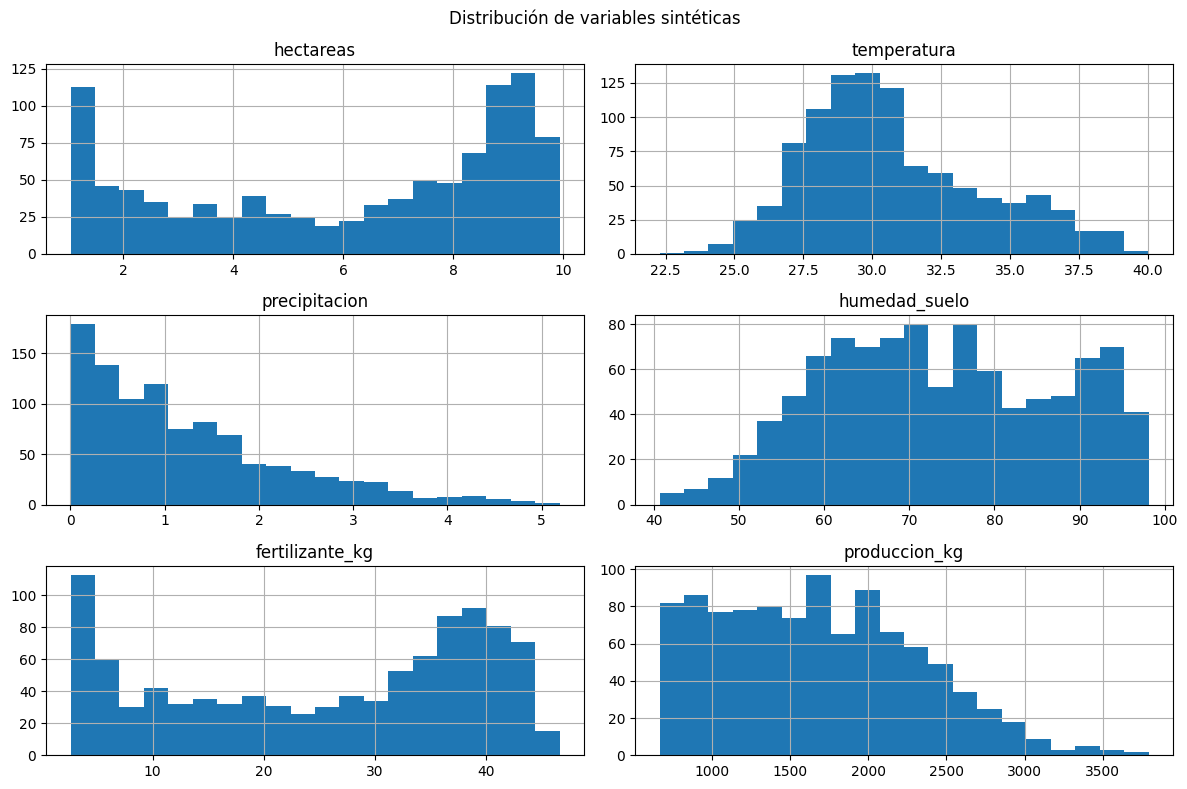

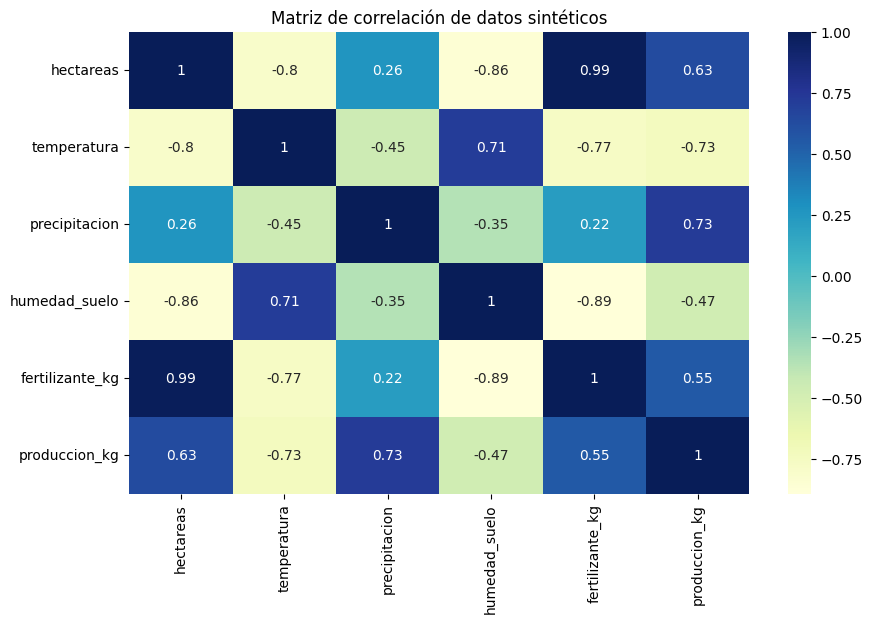

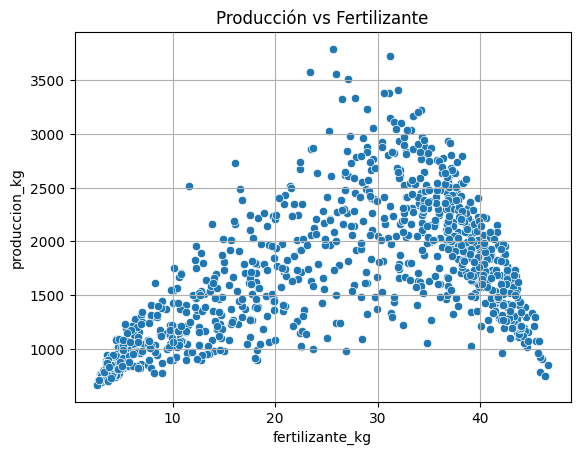

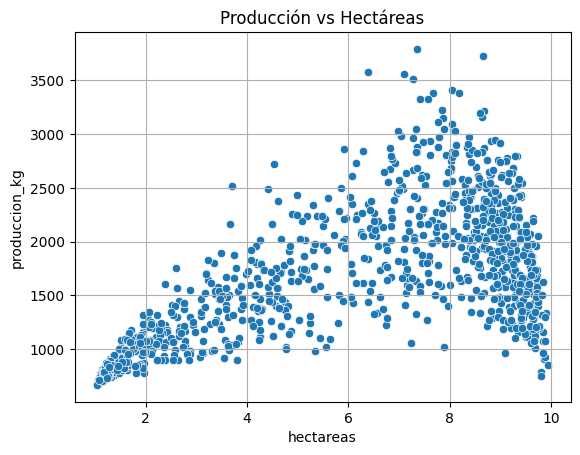

In [7]:
# Correlaciones
print("\nMatriz de correlación:")
print(df_sintetico.corr(numeric_only=True))

# Histogramas
df_sintetico.hist(bins=20, figsize=(12, 8))
plt.suptitle("Distribución de variables sintéticas")
plt.tight_layout()
plt.show()

# Mapa de calor de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df_sintetico.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.title("Matriz de correlación de datos sintéticos")
plt.show()

# Scatter plots
sns.scatterplot(x="fertilizante_kg", y="produccion_kg", data=df_sintetico)
plt.title("Producción vs Fertilizante")
plt.grid(True)
plt.show()

sns.scatterplot(x="hectareas", y="produccion_kg", data=df_sintetico)
plt.title("Producción vs Hectáreas")
plt.grid(True)
plt.show()